# Ensembles

En esta notebook, veremos de hacer un ensemble neuronal de las técnicas vistas hasta el momento (y quizás alguna más)

Vamos a usar

- Modelo char
- Modelo BoW
- Modelo ElMO


In [1]:
import pandas as pd
import csv

df_dev = pd.read_table("../../../data/es/dev_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)
df_train = pd.read_table("../../../data/es/train_es.tsv", index_col="id", quoting=csv.QUOTE_NONE)

text_train, y_train = df_train["text"], df_train["HS"]
text_dev, y_dev = df_dev["text"], df_dev["HS"]

print("Instancias de entrenamiento: {}".format(len(df_train)))
print("Instancias de desarrollo: {}".format(len(df_dev)))


Instancias de entrenamiento: 4500
Instancias de desarrollo: 500


In [2]:
import os
import glob
from hate.utils import load_embedding

path_to_embeddings = os.path.expanduser("~/WordVectors")

print("Embeddings disponibles")
print(glob.glob(path_to_embeddings+"/*.vec"))

word_to_vec = load_embedding(os.path.join(path_to_embeddings, "UBA_w5_300.vec"))

Using TensorFlow backend.


Embeddings disponibles
['/home/jmperez/WordVectors/UBA_w5_200.vec', '/home/jmperez/WordVectors/wiki.es.vec', '/home/jmperez/WordVectors/UBA_w5_300.vec']
Problema con la sig línea:
['.', '.', '-0.22232', '0.0052569', '0.47066', '0.13836', '0.15991', '0.19504', '0.00067885', '0.020299']
Problema con la sig línea:
['.', '...', '-0.11666', '-0.083768', '0.028919', '0.29973', '0.21017', '0.27808', '0.063251', '0.090223']
Problema con la sig línea:
['.', '..', '-0.43752', '-0.0016885', '0.1533', '0.28071', '0.18051', '0.28698', '0.11806', '0.044891']


Hagamos tokenize sobre el texto

In [3]:
%matplotlib inline
from nltk.tokenize import TweetTokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
import unidecode


stemmer = SnowballStemmer('spanish')

def tokenize(tweet, stem=False, deaccent=True, alpha_only=False, **kwargs):
    tokenizer = TweetTokenizer(**kwargs)
    tokens = tokenizer.tokenize(tweet)
    
    ret = []
    
    def fstem(x):
        if stem:
            return stemmer.stem(x)
        else:
            return x
        
    for token in tokens:
        tok = None
        if token[0] == "#":            
            tok = fstem(token[1:])
        elif token[0] == "@":
            tok = "@user"
        elif "http" in token:
            continue
        else:
            tok = fstem(token)
        
        if deaccent and tok.isalpha():
            tok = unidecode.unidecode(tok)
        if alpha_only and not tok.isalpha():
            continue
        
        ret.append(tok)
    return ret



## Embeddings Model

In [4]:
tokenize_args = {
    "preserve_case": False, 
    "deaccent": False,
    "reduce_len": True, 
    "strip_handles": False,
    "stem": False,
    "alpha_only": True
}

text_train = [" ".join(tokenize(t, **tokenize_args)) for t in df_train["text"].values]
text_dev = [" ".join(tokenize(t, **tokenize_args)) for t in df_dev["text"].values]


In [5]:
text_train[-1]

'no hay nada más lento que un caracol cállate hijo de puta eso lo dices porque no tienes blackberry'

In [6]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

emb_num_words = 12500

tokenizer = Tokenizer(num_words=emb_num_words)
tokenizer.fit_on_texts(text_train)

emb_train = tokenizer.texts_to_sequences(text_train)
emb_dev = tokenizer.texts_to_sequences(text_dev)


In [7]:
print("Vocabulario: {} palabras".format(len(tokenizer.word_index)))

Vocabulario: 14008 palabras


(array([525., 981., 923., 771., 415., 331., 286., 181.,  73.,  14.]),
 array([ 1. ,  6.8, 12.6, 18.4, 24.2, 30. , 35.8, 41.6, 47.4, 53.2, 59. ]),
 <a list of 10 Patch objects>)

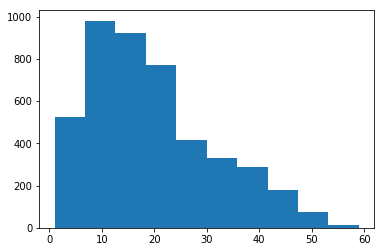

In [8]:
plt.hist([len(t) for t in emb_train])

In [9]:

emb_max_length = 50

X_emb_train = pad_sequences(emb_train, emb_max_length)
X_emb_dev = pad_sequences(emb_dev, emb_max_length)

In [10]:
# create a weight matrix for words in training docs
import numpy as np

embedding_size = word_to_vec["hola"].shape[0]
embedding_matrix = np.zeros((emb_num_words, embedding_size))

for word, i in tokenizer.word_index.items():
    embedding_vector = word_to_vec.get(word)
    if embedding_vector is not None and i < emb_num_words:
        embedding_matrix[i] = embedding_vector

## Bow Model

In [11]:

tokenize_args = {
    "preserve_case": False, 
    "deaccent": False,
    "reduce_len": True, 
    "strip_handles": False,
    "stem": True,
    "alpha_only": True
}
vect = CountVectorizer(tokenizer=lambda t: tokenize(t, **tokenize_args), 
                       max_df=0.90, min_df=0.001, ngram_range=(1, 2), binary=True)

vect.fit(df_train["text"])

X_bow_train = vect.transform(df_train["text"])
X_bow_dev = vect.transform(df_dev["text"])

X_bow_train.shape, X_bow_dev.shape

## Char Input

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

vocab_size = 200


tokenize_args = {
    "preserve_case": False, 
    "deaccent": True,
    "reduce_len": True, 
    "strip_handles": False,
    "stem": True,
    "alpha_only": False
}

text_train = [" ".join(tokenize(t, **tokenize_args)) for t in df_train["text"].values]
text_dev = [" ".join(tokenize(t, **tokenize_args)) for t in df_dev["text"].values]

char_tokenizer = Tokenizer(num_words=vocab_size, char_level=True, 
                           lower=tokenize_args["preserve_case"])
char_tokenizer.fit_on_texts(text_train)

X_char_train = char_tokenizer.texts_to_sequences(text_train)
X_char_dev = char_tokenizer.texts_to_sequences(text_dev)

(array([358., 909., 892., 801., 491., 274., 256., 264., 220.,  35.]),
 array([  5. ,  32.1,  59.2,  86.3, 113.4, 140.5, 167.6, 194.7, 221.8,
        248.9, 276. ]),
 <a list of 10 Patch objects>)

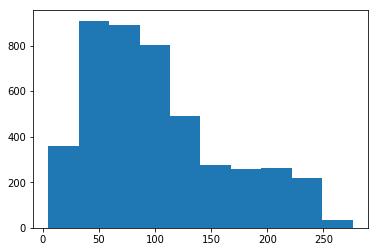

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist([len(seq) for seq in X_char_train])

Sanity check: veamos que si "destokenizo", me reconstruye algo razonable

In [14]:
print(char_tokenizer.sequences_to_texts(X_char_train[0:1]))
print(text_train[0])
print(char_tokenizer.sequences_to_texts(X_char_train[1:2]))
print(text_train[1])

["e a s y j e t   q u i e r   d u p l i c   e l   n u m e r   d e   m u j e r   p i l o t   '   v e r a s   t u   p a r   a p a r c   e l   a v i o n   . ."]
easyjet quier duplic el numer de mujer pilot ' veras tu par aparc el avion ..
['e l   g o b i e r n   d e b   c r e   u n   c o n t r o l   e s t r i c t   d e   i n m i g r   e n   l a s   z o n   f r o n t e r i z   c o n   c o l o m b i   p o r   q   d e s p u e s   d e l   2 0 - 8   q u e r r a n   v e n   e n   m a s']
el gobiern deb cre un control estrict de inmigr en las zon fronteriz con colombi por q despues del 20-8 querran ven en mas


In [15]:

max_charlen = 300

X_char_train = pad_sequences(X_char_train, maxlen=max_charlen)
X_char_dev = pad_sequences(X_char_dev, maxlen=max_charlen)

## Elmo Input

In [16]:
from keras.utils import to_categorical
import numpy as np

tokenize_args = {
    "preserve_case": False, 
    "deaccent": False,
    "reduce_len": True, 
    "strip_handles": False,
    "alpha_only": True,
}


tokens_train = [tokenize(tweet, **tokenize_args) for tweet in df_train["text"].values]
tokens_dev = [tokenize(tweet, **tokenize_args) for tweet in df_dev["text"].values]

tokens_train[0]

['easyjet',
 'quiere',
 'duplicar',
 'el',
 'número',
 'de',
 'mujeres',
 'piloto',
 'verás',
 'tú',
 'para',
 'aparcar',
 'el',
 'avión']

Ahora, calculemos los inputs de ElMO

(array([505., 959., 927., 772., 417., 336., 285., 200.,  82.,  17.]),
 array([ 1. ,  6.8, 12.6, 18.4, 24.2, 30. , 35.8, 41.6, 47.4, 53.2, 59. ]),
 <a list of 10 Patch objects>)

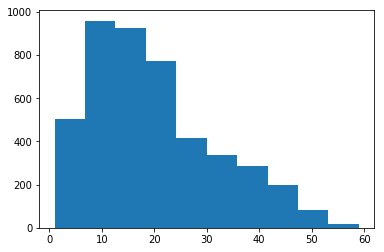

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist([len(t) for t in tokens_train])

Padeamos los vectores con espacios

In [18]:
elmo_max_length = 50

def pad_tokens(tokens, max_len):
    if len(tokens) >= max_len:
        return tokens[:max_len]
    else:
        tokens = tokens + [''] * (max_len - len(tokens))
    return tokens

padded_tokens_train = [pad_tokens(seq, elmo_max_length) for seq in tokens_train]
padded_tokens_dev = [pad_tokens(seq, elmo_max_length) for seq in tokens_dev]


In [19]:
%%capture
from elmoformanylangs import Embedder

e = Embedder("../../../models/elmo/es/")

In [20]:
import numpy as np

print(padded_tokens_train[0])

elmo_dim = 1024

elmo_train = np.array(e.sents2elmo(padded_tokens_train, -1))
elmo_dev = np.array(e.sents2elmo(padded_tokens_dev, -1))

['easyjet', 'quiere', 'duplicar', 'el', 'número', 'de', 'mujeres', 'piloto', 'verás', 'tú', 'para', 'aparcar', 'el', 'avión', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


(array([8.7644e+04, 5.0588e+04, 2.1545e+04, 3.0607e+04, 2.4557e+04,
        8.9710e+03, 1.0110e+03, 7.1000e+01, 4.0000e+00, 2.0000e+00]),
 array([13.044382, 16.201157, 19.35793 , 22.514704, 25.671478, 28.82825 ,
        31.985025, 35.1418  , 38.298573, 41.45535 , 44.61212 ],
       dtype=float32),
 <a list of 10 Patch objects>)

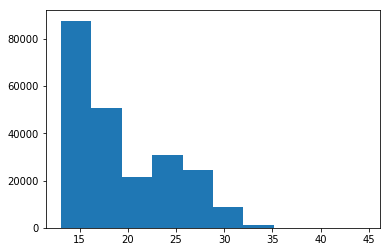

In [21]:
plt.hist([np.linalg.norm(t) for seq in elmo_train for t in seq ])

In [22]:

def pad_vectors(X, max_len, norm=False):
    pad_vector = np.zeros((1, elmo_dim))
    ret = []
    
    for seq in X:
        if norm:
            seq = seq / np.linalg.norm(seq, axis=1)[..., np.newaxis]
        if len(seq) > max_len:
            ret.append(seq[:max_len])
        else:
            padded = np.vstack([
                seq, 
                np.zeros((max_len - len(seq), elmo_dim))
            ])
            
            ret.append(padded)
        
    return ret


X_elmo_train = np.array(pad_vectors(elmo_train, elmo_max_length))
X_elmo_dev = np.array(pad_vectors(elmo_dev, elmo_max_length))

X_elmo_train.shape, X_elmo_dev.shape

((4500, 50, 1024), (500, 50, 1024))

(array([8.7644e+04, 5.0588e+04, 2.1545e+04, 3.0607e+04, 2.4557e+04,
        8.9710e+03, 1.0110e+03, 7.1000e+01, 4.0000e+00, 2.0000e+00]),
 array([13.04438215, 16.20115588, 19.35792962, 22.51470335, 25.67147708,
        28.82825081, 31.98502455, 35.14179828, 38.29857201, 41.45534574,
        44.61211947]),
 <a list of 10 Patch objects>)

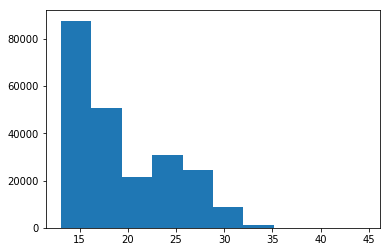

In [23]:
norms = [np.linalg.norm(t) for seq in X_elmo_train for t in seq ]

plt.hist(norms)

## Modelo múltiple inputs
Hagamos un primer modelo con múltiple inputs.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Char_Input (InputLayer)         (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 300, 64)      12800       Char_Input[0][0]                 
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 300, 128)     57472       embedding_9[0][0]                
__________________________________________________________________________________________________
Emb_Input (InputLayer)          (None, 50)           0                                            
__________________________________________________________________________________________________
max_poolin

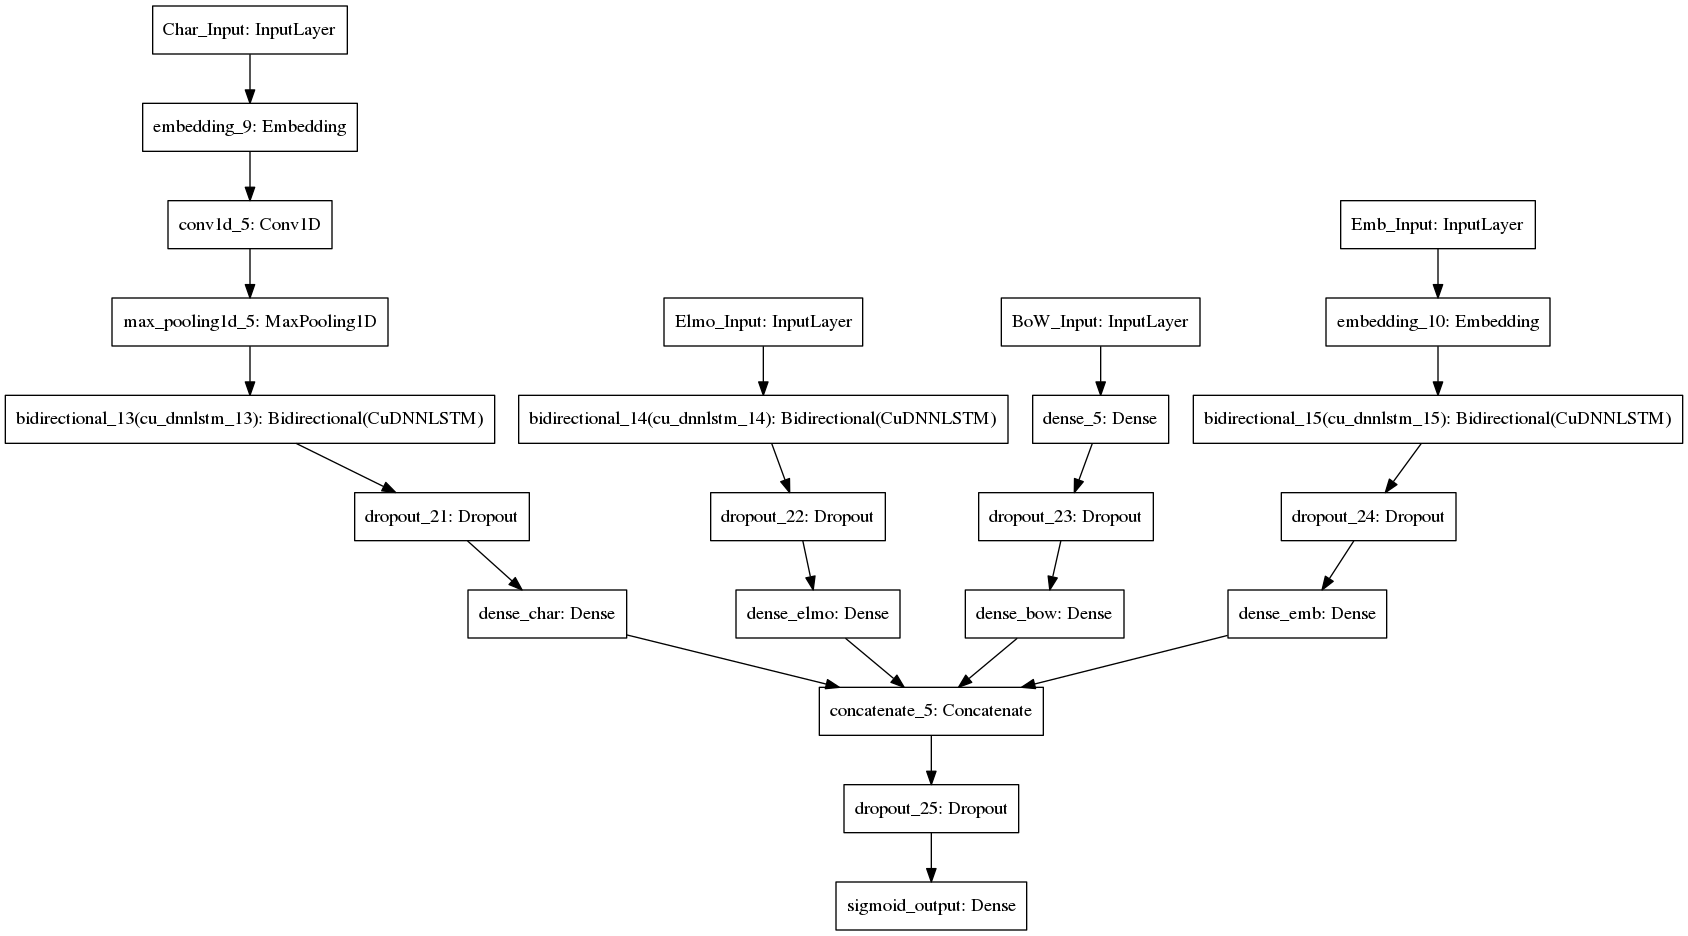

In [33]:
from keras.models import Model
from keras.layers import (
    Dense, GRU, Dropout, LSTM, Bidirectional, Embedding, GlobalAveragePooling1D,
    CuDNNLSTM, CuDNNGRU, Conv1D, MaxPooling1D, Input, Concatenate, BatchNormalization)
from keras.optimizers import Adam
from keras.utils import plot_model

recursive_class = CuDNNLSTM

def create_char_graph(max_charlen, vocab_size, embedding_dim=64, filters=128, kernel_size=6,
                      pooling_size=3, lstm_units=128, dense_units=128, dropout=[0.75, 0.50]):
    input_char = Input(shape=(max_charlen,), name="Char_Input")
    x = Embedding(vocab_size, embedding_dim)(input_char)
    x = Conv1D(filters=filters, kernel_size=kernel_size, 
               padding='same', activation='relu')(x) 
    
    x = MaxPooling1D(pool_size=pooling_size)(x)
    x = Bidirectional(recursive_class(lstm_units))(x)
    x = Dropout(dropout[0])(x)
    x = Dense(dense_units, activation='relu', name='dense_char')(x)
    
    return input_char, x


def create_elmo_graph(max_length, lstm_units=128, dense_units=128, dropout=[0.75, 0.50]):
    input_elmo = Input(shape=(max_length, elmo_dim), name="Elmo_Input")
    y = Bidirectional(recursive_class(lstm_units))(input_elmo)
    y = Dropout(dropout[0])(y)
    y = Dense(dense_units, activation='relu', name='dense_elmo')(y)
    return input_elmo, y

def create_bow_graph(input_shape, dense_units=512, dropout=[0.75, 0.50]):
    input_bow = Input(shape=input_shape, name="BoW_Input")
    z = Dense(dense_units, activation='relu')(input_bow)
    z = Dropout(dropout[0])(z)
    z = Dense(128, activation='relu', name='dense_bow')(z)
    
    return input_bow, z

def create_embeddings_graph(max_len, embedding_matrix, lstm_units=256, dense_units=128, dropout=[0.75, 0.50]):
    input_embeddings = Input(shape=(max_len, ), name="Emb_Input")

    w = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                  input_length=max_len, weights=[embedding_matrix], trainable=False)(input_embeddings)
    #w = GlobalAveragePooling1D()(w)
    w = Bidirectional(recursive_class(lstm_units))(w)
    w = Dropout(dropout[0])(w)
    w = Dense(dense_units, activation='relu', name='dense_emb')(w)
    return input_embeddings, w




dropouts = [0.75, 0.55]


input_char, output_char = create_char_graph(
    max_charlen, vocab_size, embedding_dim=64, lstm_units=64, 
    filters=128, kernel_size=7, pooling_size=4,
    dropout=dropouts)

input_elmo, output_elmo = create_elmo_graph(elmo_max_length, lstm_units=96, dropout=dropouts)
input_bow, output_bow = create_bow_graph(input_shape=(X_bow_train.shape[1],), dense_units=128, dropout=dropouts)

input_emb, output_emb = create_embeddings_graph(emb_max_length, embedding_matrix, lstm_units=64, dropout=dropouts)


use_char = True
use_elmo = True
use_bow = True
use_emb = True

X_tr = []
X_dev = []
to_merge = []
inputs = []

if use_char:
    to_merge.append(output_char)
    inputs.append(input_char)
    X_tr.append(X_char_train)
    X_dev.append(X_char_dev)
if use_elmo:
    to_merge.append(output_elmo)
    inputs.append(input_elmo)
    X_tr.append(X_elmo_train)
    X_dev.append(X_elmo_dev)    
if use_bow:
    to_merge.append(output_bow)
    inputs.append(input_bow)
    X_tr.append(X_bow_train)
    X_dev.append(X_bow_dev)
if use_emb:
    to_merge.append(output_emb)
    inputs.append(input_emb)
    X_tr.append(X_emb_train)
    X_dev.append(X_emb_dev)

    
if use_char + use_elmo + use_bow + use_emb  >= 2:
    merge_layer = Concatenate()(to_merge)
else:
    merge_layer = to_merge[0]

merge_layer = Dropout(dropouts[1])(merge_layer)
#merge_layer = Dense(64, activation='relu')(merge_layer)
output = Dense(1, name="sigmoid_output", activation='sigmoid')(merge_layer)

optimizer_args = {
    "lr": 0.0005,
    "decay": 0.01,
    "amsgrad": False
}



model = Model(inputs=inputs, outputs=[output])
model.compile(loss='binary_crossentropy', 
              optimizer=Adam(**optimizer_args), 
              metrics=['accuracy'])


from IPython.display import Image

print(model.summary())


plot_model(model, to_file='model.png')
Image('model.png')

In [34]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint('/tmp/ensemble_12.h5', save_best_only=True, monitor='val_acc', verbose=1)

model.fit(X_tr, y_train, callbacks=[checkpointer],
          validation_data=(X_dev, y_dev), epochs=80, batch_size=32)


Train on 4500 samples, validate on 500 samples
Epoch 1/80
4500/4500 [==============================] - 9s 2ms/step - loss: 0.6795 - acc: 0.5942 - val_loss: 0.6519 - val_acc: 0.6560

Epoch 00001: val_acc improved from -inf to 0.65600, saving model to /tmp/ensemble_12.h5
Epoch 2/80
4500/4500 [==============================] - 6s 1ms/step - loss: 0.6289 - acc: 0.6504 - val_loss: 0.6125 - val_acc: 0.6760

Epoch 00002: val_acc improved from 0.65600 to 0.67600, saving model to /tmp/ensemble_12.h5
Epoch 3/80
4500/4500 [==============================] - 6s 1ms/step - loss: 0.5948 - acc: 0.6867 - val_loss: 0.5787 - val_acc: 0.7080

Epoch 00003: val_acc improved from 0.67600 to 0.70800, saving model to /tmp/ensemble_12.h5
Epoch 4/80
4500/4500 [==============================] - 6s 1ms/step - loss: 0.5562 - acc: 0.7256 - val_loss: 0.5486 - val_acc: 0.7440

Epoch 00004: val_acc improved from 0.70800 to 0.74400, saving model to /tmp/ensemble_12.h5
Epoch 5/80
4500/4500 [==============================

In [35]:
from hate.utils import print_evaluation

model.load_weights('/tmp/ensemble_12.h5')


print_evaluation(model, X_dev, y_dev)

500/500 [==============================] - 0s 617us/step
Loss        : 0.3932
Accuracy    : 0.8420
Precision   : 0.8235
Recall      : 0.8198
F1          : 0.8217


In [36]:
model.save_weights("../../../models/nn/ensemble_12.h5")

## Weights

¿Cómo contribuyó cada input al output? Veamos la capa de concatenación

dense_char (Dense)              (None, 128)          16512       dropout_21[0][0]                 
__________________________________________________________________________________________________
dense_elmo (Dense)              (None, 128)          24704       dropout_22[0][0]                 
__________________________________________________________________________________________________
dense_bow (Dense)               (None, 128)          16512       dropout_23[0][0]                 
__________________________________________________________________________________________________
dense_emb (Dense)               (None, 128)          16512       dropout_24[0][0]      

In [60]:
elmo_weights, elmo_biases = model.get_layer('dense_elmo').get_weights()
bow_weights, bow_biases = model.get_layer('dense_bow').get_weights()
char_weights, char_biases = model.get_layer('dense_char').get_weights()
emb_weights, emb_biases = model.get_layer('dense_emb').get_weights()



In [65]:
elmo_weights.mean(), bow_weights.mean(), char_weights.mean(), emb_weights.mean()

(0.00084794476, 0.00657505, 0.00044106727, 0.0007584571)

Al parecer, la que tiene más "peso" promedio es BoW, luego elmo, luego embeddings, y finalmente char....?

Veamos cómo combina estos pesos recolectados para sacar el output

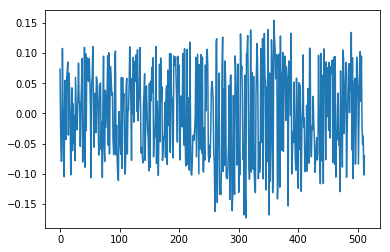

In [71]:
weights, biases = model.get_layer('sigmoid_output').get_weights()

plt.plot(weights)

In [72]:
weights[:128].mean(), weights[128:256].mean(), weights[256:384].mean(), weights[384:512].mean()

(0.0062277084, 0.0013016419, -0.009642567, -0.0021438943)

## Error Analysis

Vamos a ver los tweets con mayores errores

In [73]:
df_dev["proba"] = model.predict(X_dev)


true_positives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] >= 0.5)].copy()
true_negatives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] < 0.5)].copy()

false_positives = df_dev[(df_dev["HS"] == 0) & (df_dev["proba"] > 0.5)].copy()
false_positives.sort_values("proba", ascending=False, inplace=True)


false_negatives = df_dev[(df_dev["HS"] == 1) & (df_dev["proba"] < 0.5)].copy()
false_negatives.sort_values("proba", ascending=True, inplace=True)

conf_matrix = pd.DataFrame([
    {"real":"hs=1", "pred_true": len(true_positives), "pred_false": len(false_negatives)},
    {"real":"hs=0", "pred_true": len(false_positives), "pred_false": len(true_negatives)}
])



conf_matrix.set_index("real", inplace=True)

print("Falsos negativos: {}".format(len(false_negatives)))
print("Falsos positivos: {}".format(len(false_positives)))

conf_matrix[["pred_true", "pred_false"]]

Falsos negativos: 40
Falsos positivos: 39


,pred_true,pred_false
real,,
hs=1,182,40
hs=0,39,239


## Falsos Negativos

Veamos los 20 falsos negativos en los cuales nuestro modelo se equivoca más

In [74]:
pd.set_option('max_colwidth', 300)

false_negatives[["text", "proba"]]


,text,proba
id,,
21072,"Voy andando por la calle y me han dicho cosas en árabe ya que me estas acosando dime lo en español para que te entienda, asique como yo no les entiendo me he cagado en su puta madre en árabe para que ellos a mi si.",0.007829
21215,"Que tal otro aporte anónimo son de la puta de mi esposa, así los dejó en navidad enseñando le los calzones al vecino rt y siguenos @TANGASUCIA @Tangasrobadas https://t.co/70ioUjveqY",0.014301
21535,#VOX critica duramente a ⁦@pablocasado_⁩ “Les da la bienvenida como si fuera un cartel del welcome de #Carmena “ ¡Expulsión inmediata de moromierdas! https://t.co/HaySDibj2l,0.036465
24352,"¿Ves que tu coño me importe? Cómete mi polla, basura https://t.co/ht02KyYWZh",0.121606
24126,LA SOLUCIÓN ES SOLDARLE EL TIMÓN DE LA PATERA RUMBO DE DONDE SALIERON CON AGUA Y COMIDA. https://t.co/59pInBdgnR,0.129170
20175,"Ay Dios cuando se entere Casado de que la ola de calor viene dada por la entrada masiva, sin papeles, de aire subsahariano",0.129799
20019,"""Y NADIE SE HA PREGUNTADO LO QUE LE VA A COSTAR AL HOMBRE DEL GUANTAZO LA SITUACION..?!? PORQUE SEGURO ES, QUE EL MENDA MUSULMONO LE VA A PONER UNA DENUNCIA, QUE EL FALLO VA A SER """"CULPABLE"""", QUE UNA PANDILLA DE MUSULMONOS LE VA A ESTAR ESPERANDO DELANTE DE LA PUERTA DE SU NEGOCIO https://t.co...",0.131386
22065,| lo único que dominas es mi polla en tu cara. https://t.co/qlYOd4zPwW,0.134488
21727,"España crea su primer 'campo de refugiados' en la bahía de Algeciras https://t.co/l7Zmh2kvPN vía @elmundoes Gran noticia para el contribuyente español. Españoles a pagar, a pagar. Las pensiones pensad en las pensiones. Esto la sanidad como es gratis podemos dejar de pagarla no?",0.150273


¿Cómo los tokenizamos?

In [75]:
df_dev.loc[21841]["text"]

'La otra no noticia del día es la visita del sonriente Casado a Algeciras, a visitar en Ceuta y Algeciras, no a los guardias civiles heridos tras la violenta entrada de ilegales del otro día, sino a un grupo de subsaharianos que han entrado en nuestro país de forma igualmente ileg'

## Falsos positivos

In [76]:
pd.set_option('max_colwidth', 300)
false_positives[["text", "proba"]]

,text,proba
id,,
21050,@GvyMC @Wismichu Callate puta rata😂😂 ya estas llorando??,0.981258
24402,zorra eres tu que no te sientes hombre y no entiendes que toda mujer es bella,0.969726
21892,@saancisco Callate puta tu eres el traidor.,0.961956
24159,"@LeonDeJapon Jajajajajaja tu eres uno, diego jajajajajaja mentira perra perra perrraaaaaaaaaa de mierda jajaja ♡",0.959643
20376,"Zorra tu abuela, imbécil.",0.957004
23565,La solución no es darle papeles a todos. Es exigir a nuestro gobierno q no fabrique y venda armas a los gobiernos subsaharianos para que estos no masacren y acorralen a su población haciendo q quieran venir aquí x lo civil o criminal. Desesperación y supervivencia pura.,0.947687
22457,"De Colombia tocará emigrar en pateras, como hacen los africanos subsaharianos.",0.940329
24019,Acá nos huevean si nos encapuchamos pero en los paises árabes estariamos todas obligadas a encapucharnos 🤷‍♀️,0.933842
22416,@Pepe_ElEzequiel Puta!? Puta con las que vos te metes Esa mujer es un ángel enviado por Jesucristo nuestro señor para darnos esa paz que buscamos sólo con verla,0.887685


# Conclusiones

No mejora mucho usando embeddings también! mejor quedémonos el otro modelo...